### Handling Missing Data
Missing data is so often, we need to handle them carefully

In [1]:
## Load the relevant modules
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

In [2]:
# set random seed for reproducibility
np.random.seed(20221001)

In [4]:
# Load the data and view its shape and content
data = pd.read_csv("https://github.com/barcelonagse-datascience/academic_files/raw/master/data/titanic3.csv")

In [6]:
# explore the data
print(data.shape)
print(data.head())
print(data.columns)

(1309, 14)
   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

     age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.00      0      0   24160  211.3375       B5        S    2    NaN   
1   0.92      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.00      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St L

In [7]:
data = data.drop(['name', 'body', 'ticket', 'embarked', 'home.dest', 'boat'], axis=1)
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin
0,1,1,female,29.00,0,0,211.3375,B5
1,1,1,male,0.92,1,2,151.5500,C22 C26
2,1,0,female,2.00,1,2,151.5500,C22 C26
3,1,0,male,30.00,1,2,151.5500,C22 C26
4,1,0,female,25.00,1,2,151.5500,C22 C26


In [8]:
# check how may missing values in each col
nulls = data.isnull().mean()*100
nulls

pclass       0.000000
survived     0.000000
sex          0.000000
age         20.091673
sibsp        0.000000
parch        0.000000
fare         0.076394
cabin       77.463713
dtype: float64

Our data has 1309 rows and 8 colums.


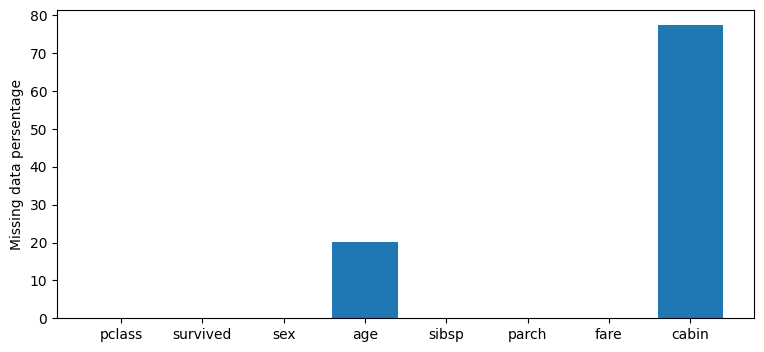

In [26]:
# plot null in each col
fig = plt.figure(figsize=(9,4))
plt.bar(nulls.index, nulls.values)
# rotate the x ticks
# plt.xticks(rotation='vertical')

# add y axis label
plt.ylabel('Missing data persentage')
print('Our data has %s rows and %s colums.' % data.shape)


we can see that _age_, _fare_, and _carbn_ have missing values, for _age_ and _fare_ the number of missing value is large.

### Methods of handling missing values

1. Remove empty colums/rows

In [32]:
# remove col 'survived'
X = data.drop('survived', axis=1)
print(data.shape)
print(X.shape)

(1309, 8)
(1309, 7)


In [44]:
# remove col with any missing value
missing_data_col = data.columns[nulls > 0]
print(missing_data_col)
data_nona = data.drop(missing_data_col, axis=1)
data_nona.shape

Index(['age', 'fare', 'cabin'], dtype='object')


(1309, 5)

In [48]:
data_nona.isna().sum()

pclass      0
survived    0
sex         0
sibsp       0
parch       0
dtype: int64

We have dealt with the NAS by removing the columns that had any NAs. But this may cost us a lot. In particular, we can no longer use the information in _age_ and _fare_ to predict _survived_ . 

In [51]:
# check the corr between fare and survived
data.fare.corr(data.survived)

0.24426546891481227

In [54]:
# or 
print(data.groupby('survived').fare.mean())
data.groupby('survived').fare.median()

survived
0    23.353831
1    49.361184
Name: fare, dtype: float64


survived
0    10.5
1    26.0
Name: fare, dtype: float64

In [56]:
# also 
data['children'] = (data.age <= 18)
data.groupby('children').survived.mean()

children
False    0.362903
True     0.492228
Name: survived, dtype: float64

This may not be a great idea.

The correlation between _fare_ and _survived_ is not negligible, so we would like to keep this variable. In addition to that, children also were more likely to survive than adults, so we also would like to keep _age_ as a predictor

An alternative to completely removing columns with some missing data is to remove rows with missing data.

Clearly, this may cost us observations, so a better strategy is to *mix* both column and row deletion:

1. Remove columns (features) with high percentage of missing data;
2. Then, for the remaining dataset, remove rows with missing data

We can use the *dropna* function to delete nas on each axis (0=rows,1=columns)
``` python
    data.dropna(axis=1, thresh=round(my_percentage_valid*len(data.index)))
```

### Propagate previous or next value

This method basically consists of filling a gap with previous or posterior observations of the same feature.

This approach would typically make sense when there is a natural ordering in data (e.g. time series), **but we have to be careful!** if the goal is prediction, it may not be a great idea to use future values to replace past values.

For an example of when this could be sensible, if we have a sequence of daily stock prices where one day is a holiday, we may just want to fill this using the last available price.

One can easily code it using $fillna$ method for dataframes:

``` python
    # backward
    my_data.fillna(method='bfill',inplace=True)

    # forward
    my_data.fillna(method='ffill',inplace=True)

```

If there are consecutive observations with missing data for the same feature, the method is recursively applied to make sure that all gaps are filled.

In [57]:
# An example of forward filling works
test_data = pd.DataFrame({'x':[1,2,3,4,5,6,7,8,9,10],'y':[1,None,3,4,5,None,None,None,9,10]})
test_data.fillna(method='ffill', inplace=True)
test_data

,x,y
0,1,1.0
1,2,1.0
2,3,3.0
3,4,4.0
4,5,5.0
5,6,5.0
6,7,5.0
7,8,5.0
8,9,9.0
9,10,10.0


In [59]:
# and backward filling
test_data = pd.DataFrame({'x':[1,2,3,4,5,6,7,8,9,10],'y':[1,None,3,4,5,None,None,None,9,10]})
test_data.fillna(method='bfill', inplace=True)
test_data

,x,y
0,1,1.0
1,2,3.0
2,3,3.0
3,4,4.0
4,5,5.0
5,6,9.0
6,7,9.0
7,8,9.0
8,9,9.0
9,10,10.0


### Replace by statistics (mean/ median/ mode)

One strategy that is typically used is to replace missing data by unconditional statistics obtained over the whole sample:
- *Mean* for numerical features where ouliers are not significant;
- *Median* for numerical features where outliers clearly affect the mean;
- *Mode* for categorical features;

E.g.:
``` python
 my_data.my_column.fillna(my_data.my_column.mean(),inplace=True)
```
This imputation strategy is interesting as it preserves the unconditional mean of the series.
This simple imputation shrinks overall values towards the unconditional mean or median, reducing variability. 

We can think of different ways to avoid this, such as replacing by *conditional* statistics, i.e using particular subgroups of data and categorical variables.

``` python
    my_data[my_col].fillna(my_data.groupby(my_category)[my_col].transform("mean"), inplace=True)
```

In [79]:
X_complete = X.copy()
X_complete['age'].fillna(X_complete.groupby('sex')['age'].transform('mean'), inplace=True)
print(X_complete.isnull().sum())
X_complete.tail(10)

pclass       0
sex          0
age          0
sibsp        0
parch        0
fare         1
cabin     1014
dtype: int64


,pclass,sex,age,sibsp,parch,fare,cabin
1299,3,male,27.000000,1,0,14.4542,NaN
1300,3,female,15.000000,1,0,14.4542,NaN
1301,3,male,45.500000,0,0,7.2250,NaN
1302,3,male,30.585228,0,0,7.2250,NaN
1303,3,male,30.585228,0,0,14.4583,NaN
1304,3,female,14.500000,1,0,14.4542,NaN
1305,3,female,28.687088,1,0,14.4542,NaN
1306,3,male,26.500000,0,0,7.2250,NaN
1307,3,male,27.000000,0,0,7.2250,NaN
1308,3,male,29.000000,0,0,7.8750,NaN


In [ ]:
X.tail(10)

,pclass,sex,age,sibsp,parch,fare,cabin
1299,3,male,27.0,1,0,14.4542,NaN
1300,3,female,15.0,1,0,14.4542,NaN
1301,3,male,45.5,0,0,7.2250,NaN
1302,3,male,NaN,0,0,7.2250,NaN
1303,3,male,NaN,0,0,14.4583,NaN
1304,3,female,14.5,1,0,14.4542,NaN
1305,3,female,NaN,1,0,14.4542,NaN
1306,3,male,26.5,0,0,7.2250,NaN
1307,3,male,27.0,0,0,7.2250,NaN
1308,3,male,29.0,0,0,7.8750,NaN


In [111]:
# do it manully 

X_complete = X.copy()
na_idx = X_complete['age'].isna() # find the indices of the missing age value

sex_na = X_complete[na_idx]['sex'] # find the gender of those observations which missing age value

my_mean = X.groupby('sex').age.mean() # get the mean age for each gender
replace_age = my_mean[sex_na].reset_index()# merge my_mean with sex_na & add index to replace values 
replace_age.set_index(sex_na.index, inplace=True) # set replacement index as those that need to be replaced

X_complete.loc[sex_na.index, 'age'] = replace_age['age']
X_complete[na_idx][['age', 'sex']]



,age,sex
15,30.585228,male
37,30.585228,male
40,30.585228,male
46,30.585228,male
59,28.687088,female
...,...,...
1293,30.585228,male
1297,30.585228,male
1302,30.585228,male
1303,30.585228,male


### Using models to impute data

We can also use formal statistical models to impute data. 

In particular, we can just treat the missing data as a prediction problem, and predict the missing value using any of the models we will see in the upcoming lectures. There are also other more complex ways of dealing with this, but we will not go in more detail. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) for more details.


### Feature transformation

### Binning

This is process of aggregating a continuous variable into bins. For example, from *grades* to *grade_class* (A, B, C).

Check $sklearn$ function [`KBinsDiscretizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer).

### Log transform
You may want to consider log transformations of your variables (this is very standard in economics and finance). Takings logs may decrease the effect of outliers on our models and provide a natural interpretation of coefficients in percentage terms.

Note that the log should be used with caution for negative or zero valued random variables (one may use log (abs(x+1)) plus a dummy for negatives)

### Example
Toy example with titanic dataset.


In [114]:
# load it again to use features we had previously deleted
data = pd.read_csv("https://github.com/barcelonagse-datascience/academic_files/raw/master/data/titanic3.csv")

data.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [116]:
data.fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

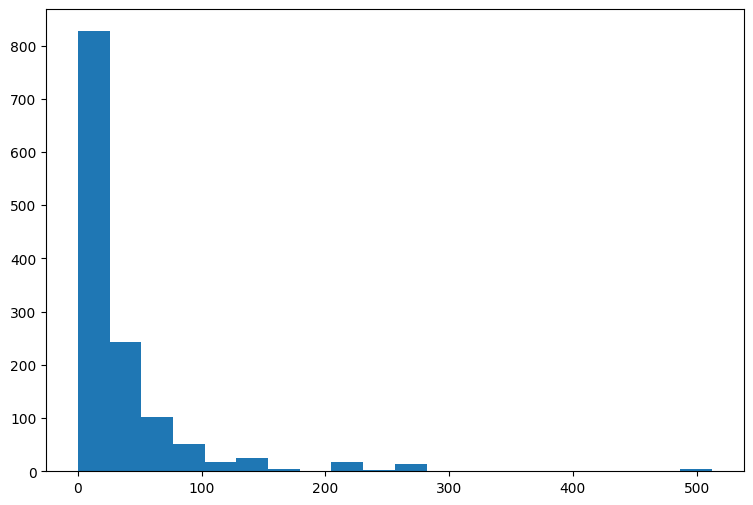

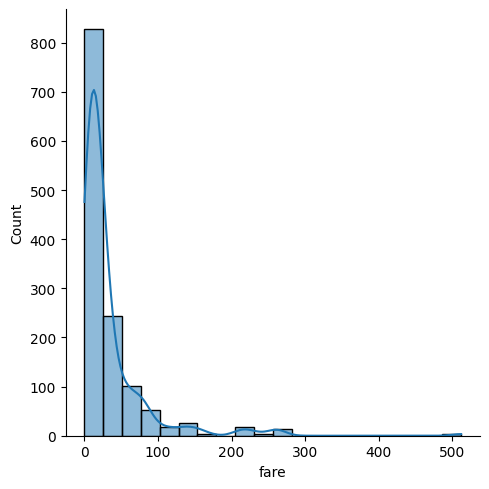

In [176]:
# plot the distribution of fare with histogram, density plot
fig = plt.figure(figsize=(9, 6))
plt.hist(data.fare, bins=20)

# by using sns
sns.displot(data.fare, kde=True, bins=20)

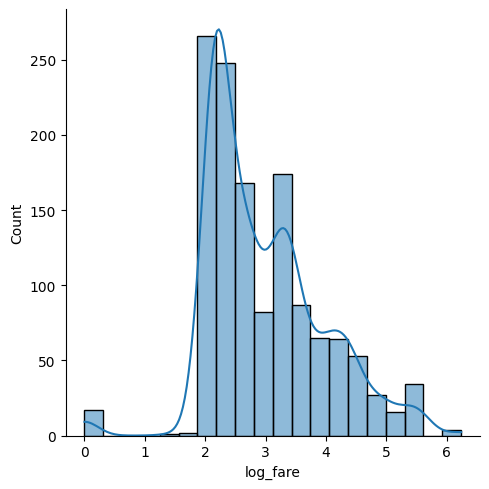

In [143]:
# construct the log of the fare
data['log_fare'] = np.log(data.fare + 1) # remember there is 0 in the value

sns.displot(data.log_fare, kde=True, bins=20)

### Scaling (Normalization/Standardization)

We typically want variables to have, loosely speaking, a sensible scale.
A few usual options are ( see also [$sklearn.preprocessing$](https://scikit-learn.org/stable/modules/preprocessing.html) ):

+ [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): Removes the mean and scales to unit variance. This is the standard definition of scaling. After the transformation, all variables have the same mean (0) and variance (1).

+ [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Similar to the StandardScaler but more robust to outliers. Removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). Note that now output won't have a mean of 0 and a standard deviation of 1
+ [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Linear scaling to an output range, just considering the minimum and maximum. Just note that default range is (0,1). The output is not necessarily _well behaved_  and this is very sensible to outliers.


In [163]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

SS = StandardScaler()
RS = RobustScaler()
MMS = MinMaxScaler()

data['fare_SS'] = SS.fit_transform(data[['fare']])
data['fare_RS'] = RS.fit_transform(data[['fare']])
data['fare_MMS'] = MMS.fit_transform(data[['fare']])

data[['fare_SS', 'fare_RS', 'fare_MMS']].describe()

,fare_SS,fare_RS,fare_MMS
count,1.308000e+03,1308.000000,1308.000000
mean,-8.691654e-17,0.805899,0.064988
std,1.000382e+00,2.213877,0.101026
min,-6.435292e-01,-0.618250,0.000000
25%,-4.909206e-01,-0.280523,0.015412
50%,-3.641609e-01,0.000000,0.028213
75%,-3.905147e-02,0.719477,0.061045
max,9.258680e+00,21.295639,1.000000


<AxesSubplot: xlabel='fare_MMS', ylabel='Count'>

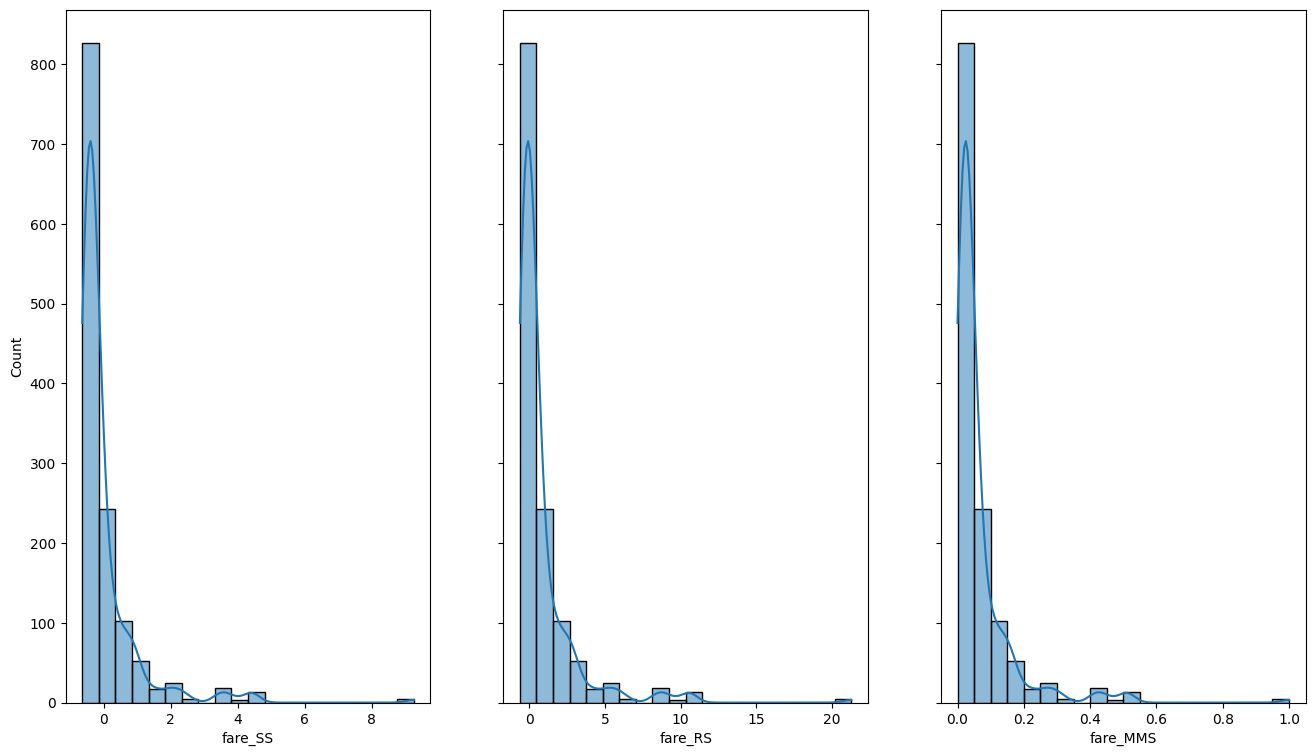

In [177]:
# plot the standardized data

fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(16, 9),
                         sharey=True)

sns.histplot(data.fare_SS, kde=True, bins=20, ax=axes[0])
sns.histplot(data.fare_RS, kde=True, bins=20, ax=axes[1])
sns.histplot(data.fare_MMS, kde=True, bins=20, ax=axes[2])

### Feature Split

Especially valid for categorical data. After data exploration, you may observe that there is some structure in your data that you may want to exploit. One way to do so would be to split the data using some heuristics.

For example, for the titanic dataset, the *cabin* column has values such as B22, C12, A4, which indicates that it's probably worth to split into two (e.g. B+22, C+12, A+4) for a better representation of a spatial distribution of cabins. With hotel rooms, it may be similar (e.g. room 112 into 1(floor)+12(room number)).

In [178]:
data.cabin.head()

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

In [195]:
# Cabin has a few NAS, for simplicity of exposition, lets replace them with a clear NA string

data.cabin.fillna('0000000', inplace=True)

# Split cabin in two
data['cabin1'] = [x.split()[0][0] for x in data.cabin]
data['cabin2'] = [x.split()[0][1:] for x in data.cabin]
data[['cabin','cabin1','cabin2']].head(10)

,cabin,cabin1,cabin2
0,B5,B,5
1,C22 C26,C,22
2,C22 C26,C,22
3,C22 C26,C,22
4,C22 C26,C,22
5,E12,E,12
6,D7,D,7
7,A36,A,36
8,C101,C,101
9,0000000,0,000000


### Date-time category extraction

From a date input, it might be useful to extract features like *day of week*, *month*, *year*, etc.. These could be important if there is some seasonality related to those units of measure.  For example, dummies like *Holiday_period* or *Working_day* might be important.

### Combine Sparse Classes
When dealing with categories, you might test the frequency of certain classes, and group the less frequent classes, but making sure that their behavior is similar with respect to the target to predict. 


### Outlier detection

Training our model on data that has *strange* observations may be misleading.

That's why it might be important to remove or treat those observations from our training dataset. Also identifying those in the test set for prediction is important, because one should expect bad performance of our model on those.

Outliers in the target output are also interesting to isolate in a regression problem.

Here we point out some methods of outlier detection:
- One dimension:
    - **Standard Deviation method**: Values beyond $|\bar{x}+k\sigma|$, for some $k>0$ (typically, $k=3$ could be a choice). 
    - **Interquartile Range method**: Values below $Q_1-1.5IQR$ or above $Q_3+1.5IQR$, which is the criteria used for boxplots. $Q_1$ and $Q_3$ are quartiles, $IQR$ the interquartile range.
- Multiple dimensions:
    - [**Mahalanobis distance** with Minimum Covariance Determinant estimator (MCD)](https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html). Just for numerical features, and better if they have been normalized.
    - [**Isolation forests**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html), a tree-based anomaly detection algorithm. Main idea: do random cuts in the dataset until we isolate observations. When a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.
    - [**Local Outlier Factor**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html). Main idea is to locate those examples that are far from the other examples in the feature space, using certain measure of distance, following nearest neighbor general idea. 
    - [**One-Class SVM**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html). It turns out that we can frame outlier detection as a classification problem with only one class using SVM. Depending on the kernel, we find a non-linear boundary for outliers. Find an [example here](https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py).
    
Check this [complete example](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py) for comparing methods for a particular use case.

As an alternative to $sklearn$, you can check the Python Outlier Detection package [$PyOD$](https://github.com/yzhao062/pyod), that includes many more methods including neural networks and autoencoders. 

### Caution: 
Outliers should not *always* be thrown out. For instance, for economic time series, should we "trim" out the covid-19 crisis episode?

## Feature generation

### Create interaction features
Linearity is a convenient modeling assumption, but it may be restrictive. It then becomes useful to consider interaction between features (or feature transformations) to capture relevant nonlinearities. We will see more about this in a bit.

### Numerical features

We may, for instance, consider polynomials of some inputs by raising them to a certain power. We may also consider cross-products of inputs (e.g. convert units sold to revenue by multiplying by prices), sums (e.g. if they are two subcategories), differences (e.g. difference in date) or ratios (e.g. students per professor) between two input features. 

If you don't scale your data, you can also create *ratios* or *differences* of features versus an average value.

In terms of out-of-the box functions, to generate polynomial features you can use [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), find an [example here](https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/).
Here you have another [example](https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755) that explores just for a linear model combinations of features using `itertools.combinations` to generate them. 

Alternatively, we may prefer methods that explicitly incorporates nonlinearties, such as *decision trees* or *neural networks*. 

### Adding domain knowledge
This simple step basically consists of adding as features any relevant information that you may have about your data. Generally speaking, one can easily include some information as a dummy or category.

Easiest example is adding 'events' to a time series, such as sovereign debt crisis, housing debt crisis etc. This helps the model to treat a subset of data in a different way. 

### Adding External data
Not having a good understanding of the context of your prediction problem may lead you to miss some relevant factors that affect your outcome. This is a hint for you to complement your input data with external information that might be relevant.

You may probably scrape data on internet to find this external data.

Here some examples:
+ Context Economic indicators (GDP, average salary, etc.), political indicators, social indicators, etc.
+ Time series evolution/pattern of similar entities.
+ Geographical info: From city, region info, obtain average position (UTM coordinates, latitude, longitude), so that you can identify neighbor observations (even add average features of close observations). The inverse also holds: from latitude/longitude or coordinates, compute not only features of neighbor observations, but also categories such as country, city, region, etc.

## Error Analysis
After one modeling round, this consists of analyzing your errors and trying to find patterns related to your inputs. For instance, you may infer that your performance is poor for a particular city, or social class, or a combination of those. This would give you some hints to improve your feature engineering. You might do some clustering on you *'bad prediction'* dataset, to help you detect patterns.

You can also check observations with huge errors (especially for regression problems), which may lead you to new data preprocessing (e.g. outlier management), or to a new feature engineering step.

## Hints for practitioners

### Quick imputation

For a quick fix, one can use $sklearn.impute.SimpleImputer$ function, that has following parameters:

+ *missing_values* : Which value has to be considered as a missing value.
+ *strategy* : The imputation strategy ('mean', 'median', 'most_frequent', 'constant'), by column of missing data
+ *fill_value* : Assign string or numerical value, optional (default=None)
+ *add_indicator* : boolean. Creates a boolean feature (column) per column with missing data 

### Missing indicator: Don't lose information

Add boolean columns to keep track of data that was originally missing.

``` python
dataframe['is_null_Column_Name'] = dataframe.Column_Name.isnull().astype(int)
```
As an alternative, use $sklearn.impute.MissingIndicator$.


### Time series imputation
Filling gaps in time series is a particular case of handling missing data. 
Time series vary by nature, but there are a few common patterns.

Often, there are missing values in the _beginning_ of the dataframe. A general solution here is to start analysis at a later date, when this is possible.

Alternatively, there may be missing values in the _end_ of the dataframe due to some series being updated faster than others. A general solution here is to cut-off the last, say, couple of observations.

More problematic cases happen when we have missing data in the _middle_ of the dataframe. If the missing data is randomly missing, a suggestion is to simply use the mean of the column. **However**, if the missing data is due to a particular event (say a stock market's circuit breakers), then the mean may be an overly optimistic value for the missing value, and care must be taken.

In addition, interpolation may be used for time series as well.

## Making pipelines
$Sklearn$ library *pipeline* allows sequencing your tasks and quickly build a pipeline to transform you data and apply any model.

```python
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())
model.fit(X, y)
```

## *ColumnTransformer*

sklearn $ColumnTransformer$ allows to generate different pipelines for different columns. Very useful when splitting the preprocessing for categorical and numerical columns, for instance.

Check [this example](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py) from sklearn documention for a joint use of ColumnTransformer and Pipeline.


In [247]:
# Example of missing indicator generation

from sklearn.impute import MissingIndicator
indicator = MissingIndicator(features='missing-only')

indicator.fit(X)
print(X.isnull().sum())

X2 = pd.DataFrame(indicator.transform(X))
nulls = X.isnull().sum()
X2.columns = X.columns[nulls > 0]
X2.sum()



pclass       0
sex          0
age        263
sibsp        0
parch        0
fare         1
cabin     1014
dtype: int64


age       263
fare        1
cabin    1014
dtype: int64

### References

Casari, A., Zheng, A., 2018. *Feature Engineering for Machine Learning*. O'Reilly Media.

Kuhn, M., Johnson, K. . 2019. [*Feature Engineering and Selection: A Practical Approach for Predictive Models*](http://www.feat.engineering/)

Skit-Learn documentation. [*Feature extraction*](https://scikit-learn.org/stable/modules/feature_extraction.html)

Scikit-learn documentation. *Imputing missing values with variants of IterativeImputer*.  https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

